<i>Copyright (c) Microsoft Corporation. All rights reserved.</i>

<i>Licensed under the MIT License.</i>

# Hard Negative Sampling for Image Classification

You built an image classification model, evaluated it on a validation set and got a decent accuracy. Now you deploy the model for the real-world scenario. And soon, you may find that the model performs worse than expected.

This is quite common scenario (and inevitable) when we build a machine learning model because we cannot collect all the possible samples. Your model is supposed to learn the features that describe the target classes the best, but in reality, it learns the best features to classify your dataset. For example, if we have photos of *butterfly* on a flower, the model may learn flower shapes to classify *butterfly*.

<img src="./media/hard_neg_ex1.jpg" width="300"> | <img src="./media/hard_neg_ex2.jpg" width="300"> 
---|---
Did our model learn a butterfly? | or yellow flowers?

Hard negative sampling (or hard negative mining) is a useful technique to address this pitfall. It is a way to explicitly create examples for your training set from falsely classified samples. The technique is widely used when you cannot add all the negative samples since (i) training time would get too slow because of too many training samples; and (ii) many of the negative images are trivial for the model and hence the model would not learn anything. Therefore, we try to identify the images which make a difference when added to the training set.

In this notebook, we train our model on a training set as usual, test the model on un-seen negative examples and see if the model classifies them correctly. If not, we introduce those samples into the training set and re-train the model on them.

# Overview

Our goal is to train a classifier which can recognize *fridge obejcts* (`watter_bottle`, `carton`, `can`, and `milk_bottle`), similar to [01_train notebook](./01_training_introduction.ipynb). However, the input image might not even contain any of these objects in the real use-case. Therefore, we also introduce `negative` class.

<img src="./media/hard_neg.jpg" width="600"/>

The overall training process is as follows: 
* First, prepare training set <i>T</i> and negative-sample set <i>U</i>. <i>T</i> may include initial negative samples
* Next, load a pre-trained ImageNet model
* And then, mine hard negative samples by following steps as shown in the figure:
    1. Train the model on <i>T</i>
    2. Score the model on <i>U</i>
    3. Identify hard images the model mis-classified, annotate them and add to <i>T</i> so that the model can learn the patterns it confused before.
* Finally, repeat these steps until we get a good accuracy.

In [1]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
import numpy as np
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from tempfile import TemporaryDirectory
from typing import Tuple
import torch
import torchvision
from torchvision import transforms
import scrapbook as sb

from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.classification.data import Urls as UrlsIC
from utils_cv.detection.dataset import DetectionDataset
from utils_cv.detection.plot import (
    display_bboxes,
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_detection_vs_ground_truth,
)
from utils_cv.detection.model import DetectionLearner, _get_det_bboxes, get_pretrained_fasterrcnn
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend('TkAgg')

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.4.0
Torch is using GPU: Tesla V100-PCIE-16GB


In [2]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
#DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
DATA_PATH = "C:/Users/pabuehle/Desktop/ComputerVision/data/odRefrigerator"
NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)

# Number of negative samples to add for each iteration of negative mining
NEGATIVE_NUM = 10

# Using fast_inference parameters from 03_training_accuracy_vs_speed notebook.
EPOCHS = 10
LEARNING_RATE = 0.005
BATCH_SIZE = 2 

IM_SIZE = 600
rpn_pre_nms_top_n_train = 2000
rpn_pre_nms_top_n_test = 1000 
rpn_post_nms_top_n_train = 2000 
rpn_post_nms_top_n_test = 1000

# Temporary folder to store datasets for hard-negative mining
NEGATIVE_MINING_DATA_DIR = TemporaryDirectory().name

# Train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


## 1. Prepare datasets

We prepare our dataset in the following way:
* The initial training set `T` to include *fridge objects* as well as some initial *negative samples*<sup>+</sup>.
* Negative image set `U`.
* Validation set `V` to have both *fridge objects* and *negative samples*. We evaluate our model on this set.

<sub>+ We added `NEGATIVE_NUM` of negative samples to our initial training set. In a real use-case, you may want to include 100 or more images of negative samples.</sub>

In [4]:
#ori_datapath = Path(DATA_PATH)
# # We split positive samples into 80% training and 20% validation
# data_imlist = (
#     ImageList.from_folder(ori_datapath)
#     .split_by_rand_pct(valid_pct=0.2, seed=10)
#     .label_from_folder()
# )

# We use 80% of negative images for hard-negative mining (set U) while 20% for validation
#neg_datapath = Path(NEG_DATA_PATH)
# neg_data = (
#     ImageList.from_folder(neg_datapath)
#     .split_by_rand_pct(valid_pct=0.2, seed=10)
#     .label_const()  # We don't use labels for negative data
#     .transform(size=IMAGE_SIZE)
#     .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
#     .normalize(imagenet_stats)
# )
# # Do not shuffle U when we predict
# neg_data.train_dl = neg_data.train_dl.new(shuffle=False)

# We split positive samples into 75% training and 25% validation
data = DetectionDataset(DATA_PATH, train_pct=0.75)
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

# We use most of negative images for hard-negative mining (set U) and remaining to test how often 
# our model incorrectly fires on these negative images.
neg_data = DetectionDataset(NEG_DATA_PATH, train_pct=0.80, batch_size=BATCH_SIZE, 
                            im_dir = "", require_annotation_files = False)
print(
    f"Negative dataset split into {len(neg_data.train_ds)} candidates for hard negative mining, and {len(neg_data.test_ds)} test images."
) 

../..\utils_cv\detection\dataset.py:62: FutureWarning: The behavior of this method will change in future versions.  Use specific 'len(elem)' or 'elem is not None' test instead.
  if root.find("path"):


Training dataset: 23 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x0000018A8F09DB00> 
Testing dataset: 7 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x0000018A8F0B5198>
Negative dataset split into 52 candidates for hard negative mining, and 12 test images.


In [7]:

# MAYBE NO NEED TO DO THAT HERE. COULD JUST ADD FIRST TIME THE MOST RELEVANT ONES.

# Add random NEGATIVE_NUM negatives to the training data
neg_im_indices = np.random.randint(len(neg_data.train_ds.dataset.im_paths)-1, size=NEGATIVE_NUM)
for idx in neg_im_indices:
    data.im_paths.append(neg_data.train_ds.dataset.im_paths[idx])
    data.anno_bboxes.append(neg_data.train_ds.dataset.anno_bboxes[idx])
    data.train_ds.indices.append(len(data.im_paths)-1)

data.init_data_loaders()
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

In [ ]:
# datapath = Path(NEGATIVE_MINING_DATA_DIR)/'data'

# # Training set T
# copy_files(data_imlist.train.items, datapath/'train', infer_subdir=True)
# # We include first NEGATIVE_NUM negative images in U (neg_data.train_ds) to our initial training set T
# copy_files(neg_data.train_ds.items[:NEGATIVE_NUM], datapath/'train'/'negative')

# # Validation set V
# copy_files(data_imlist.valid.items, datapath/'valid', infer_subdir=True)
# copy_files(neg_data.valid_ds.items, datapath/'valid'/'negative')

In [ ]:
#set_random_seed(10)

In [ ]:
# data = (
#     ImageList.from_folder(datapath)
#     .split_by_folder()
#     .label_from_folder()
#     .transform(size=IMAGE_SIZE)
#     .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
#     .normalize(imagenet_stats)
# )
# data.show_batch()

## 2. Prepare a model

We use *fast inference* setup we demonstrated from [02_training_accuracy_vs_speed notebook](./02_training_accuracy_vs_speed.ipynb). The model is Resnet18 and pre-trained on [ImageNet](http://www.image-net.org/). Regarding the details about training concept, please see [01_training notebook](./01_training_introduction.ipynb).

In [19]:
model = get_pretrained_fasterrcnn(
    num_classes=len(data.labels) + 1, min_size=IM_SIZE, max_size=IM_SIZE
)
detector = DetectionLearner(data, model=model)
print(f"Model: {type(detector.model)}")

Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [20]:
# We record train and valid accuracies for later analysis
train_acc = []
valid_acc = []
interpretations = []

## 3. Train the model on *T*

<a id='train'></a>

From this section to the end, we do training and negative mining. As described in the Overview section, You may need to do repeat the negative mining steps several times to achieve good results.

In [21]:
# Show the number of repetitions you went through the negative mining
print(f"Ran {len(interpretations)} time(s)")

Ran 0 time(s)


In [22]:
detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30)

Epoch: [0]  [ 0/17]  eta: 0:04:50  lr: 0.000317  loss: 3.8255 (3.8255)  loss_classifier: 1.6257 (1.6257)  loss_box_reg: 0.2987 (0.2987)  loss_objectness: 1.5744 (1.5744)  loss_rpn_box_reg: 0.3267 (0.3267)  time: 17.1056  data: 0.7979  max mem: 883
Epoch: [0]  [16/17]  eta: 0:00:01  lr: 0.005000  loss: 1.2414 (1.6329)  loss_classifier: 0.6446 (0.7768)  loss_box_reg: 0.2987 (0.3218)  loss_objectness: 0.0804 (0.3523)  loss_rpn_box_reg: 0.1332 (0.1821)  time: 1.2107  data: 0.1327  max mem: 1329
Epoch: [0] Total time: 0:00:20 (1.2116 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.1250 (0.1250)  evaluator_time: 0.0156 (0.0156)  time: 0.2656  data: 0.1250  max mem: 1329
Test:  [3/4]  eta: 0:00:00  model_time: 0.0312 (0.0586)  evaluator_time: 0.0156 (0.0117)  time: 0.1797  data: 0.1055  max mem: 1329
Test: Total time: 0:00:00 (0.1836 s / it)
Averaged stats: model_time: 0.0312 (0.0586)  evaluator_time: 0.0156 (0.0117)
Accumulating evaluation results...
DONE (

Epoch: [4]  [ 0/17]  eta: 0:00:02  lr: 0.005000  loss: 0.1824 (0.1824)  loss_classifier: 0.0630 (0.0630)  loss_box_reg: 0.0313 (0.0313)  loss_objectness: 0.0051 (0.0051)  loss_rpn_box_reg: 0.0830 (0.0830)  time: 0.1562  data: 0.0625  max mem: 1329
Epoch: [4]  [16/17]  eta: 0:00:00  lr: 0.005000  loss: 0.2012 (0.1977)  loss_classifier: 0.0630 (0.0681)  loss_box_reg: 0.0379 (0.0401)  loss_objectness: 0.0045 (0.0051)  loss_rpn_box_reg: 0.0795 (0.0844)  time: 0.1835  data: 0.0776  max mem: 1329
Epoch: [4] Total time: 0:00:03 (0.1847 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0469 (0.0469)  evaluator_time: 0.0156 (0.0156)  time: 0.1875  data: 0.1250  max mem: 1329
Test:  [3/4]  eta: 0:00:00  model_time: 0.0313 (0.0393)  evaluator_time: 0.0156 (0.0117)  time: 0.1607  data: 0.1057  max mem: 1329
Test: Total time: 0:00:00 (0.1607 s / it)
Averaged stats: model_time: 0.0313 (0.0393)  evaluator_time: 0.0156 (0.0117)
Accumulating evaluation results...
DONE (

Epoch: [8]  [ 0/17]  eta: 0:00:03  lr: 0.000500  loss: 0.0947 (0.0947)  loss_classifier: 0.0253 (0.0253)  loss_box_reg: 0.0229 (0.0229)  loss_objectness: 0.0092 (0.0092)  loss_rpn_box_reg: 0.0373 (0.0373)  time: 0.2031  data: 0.0937  max mem: 1330
Epoch: [8]  [16/17]  eta: 0:00:00  lr: 0.000500  loss: 0.0914 (0.0874)  loss_classifier: 0.0244 (0.0263)  loss_box_reg: 0.0166 (0.0168)  loss_objectness: 0.0049 (0.0049)  loss_rpn_box_reg: 0.0338 (0.0394)  time: 0.1984  data: 0.0958  max mem: 1330
Epoch: [8] Total time: 0:00:03 (0.1993 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:00  model_time: 0.0499 (0.0499)  evaluator_time: 0.0050 (0.0050)  time: 0.1798  data: 0.1249  max mem: 1330
Test:  [3/4]  eta: 0:00:00  model_time: 0.0312 (0.0398)  evaluator_time: 0.0000 (0.0052)  time: 0.1481  data: 0.0992  max mem: 1330
Test: Total time: 0:00:00 (0.1486 s / it)
Averaged stats: model_time: 0.0312 (0.0398)  evaluator_time: 0.0000 (0.0052)
Accumulating evaluation results...
DONE (

The following cell shows confusion matrix for the validation set. If you are repeating the negative mining steps, you will see all the confusion matrices from the repetitions.

In [29]:
# Get accuracy on test set at IOU=0.5:0.95
acc = float(detector.ap[-1])
valid_acc.append(acc)
acc

0.706998271255697

In [ ]:
#interpretations.append(ClassificationInterpretation.from_learner(learn))
#for i, interp in enumerate(interpretations):
#    interp.plot_confusion_matrix()

In [30]:
# Store train and valid accuracy
#train_acc.extend(np.array(learn.train_metrics_recorder.train_metrics)[:, 0])
#valid_acc.extend(np.array(learn.train_metrics_recorder.valid_metrics)[:, 0])

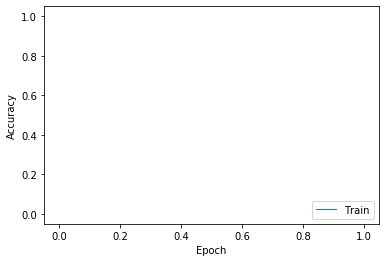

In [35]:
from utils_cv.common.plot import line_graph
line_graph(
    values=(train_acc), #, valid_acc),
    labels=("Train"), #, "Valid"),
    x_guides=[i*EPOCHS for i in range(1, len(valid_acc)//EPOCHS + 1)],
    x_name="Epoch",
    y_name="Accuracy",
)

**If the model performs well enough, we can stop the training / negative sampling here.**

If not, let's do hard negative sampling.

## 4. Score the model on *U* 

In [37]:
detections = detector.predict_dl(neg_data.train_dl, threshold=0)
#pred_outs = np.array(get_preds(learn, neg_data.train_dl)[0].tolist())
#print(f"Prediction results:\n{pred_outs[:10]}\n...")

## 5. Hard negative mining

In [67]:
max_scores = []
for idx, detection in enumerate(detections):
    if len(detection['det_bboxes']) > 0:
        max_score = max([d.score for d in detection['det_bboxes']])
        max_scores.append((max_score, idx))
max_scores

[(0.237814798951149, 6),
 (0.8555631041526794, 10),
 (0.893003523349762, 12),
 (0.5839400887489319, 13),
 (0.4500601291656494, 14),
 (0.69319748878479, 17),
 (0.6458784937858582, 18),
 (0.2566404342651367, 22),
 (0.4924968481063843, 26),
 (0.7386099100112915, 31),
 (0.8763371706008911, 39),
 (0.9042614102363586, 41),
 (0.15307456254959106, 42),
 (0.9075649976730347, 48)]

In [ ]:
# Get top-n images ranked by their maximum over all detection scores 


preds = np.argmax(pred_outs, axis=1)
wrong_ids = np.where(preds!=data.classes.index('negative'))[0]
wrong_ids_confs = [(i, pred_outs[i][preds[i]]) for i in wrong_ids]
wrong_ids_confs = sorted(wrong_ids_confs, key=lambda l:l[1], reverse=True)[:NEGATIVE_NUM]

In [ ]:
negative_sample_ids = [w[0] for w in wrong_ids_confs]
negative_sample_labels = [f"Pred: {data.classes[preds[w[0]]]}\nConf: {w[1]:.3f}" for w in wrong_ids_confs]
show_ims(neg_data.train_ds.items[negative_sample_ids], negative_sample_labels, rows=NEGATIVE_NUM//5)

## 6. Add hard negative samples to the training set *T*

We add the hard negative samples into the training set.

In [ ]:
copy_files(neg_data.train_ds.items[negative_sample_ids], datapath/'train'/'negative')

In [ ]:
# Reload the dataset which includes more negative-samples
data = (ImageList.from_folder(datapath)
        .split_by_folder()
        .label_from_folder()
        .transform(size=IMAGE_SIZE) 
        .databunch(bs=BATCH_SIZE, num_workers = db_num_workers()) 
        .normalize(imagenet_stats))
print(data.batch_stats)

# Set the dataset to the learner
learn.data = data

Now, let's go **back** to the "[3. Train the model on T](#train)" and repeat the training and negative mining steps while we have a decent accuracy on `negative` samples

In [ ]:
# Finally, show the number of repetitions you went through the negative mining
print(f"Ran {len(interpretations)} time(s)")

In [ ]:
# Preserve some of the notebook outputs
sb.glue("train_acc", train_acc)
sb.glue("valid_acc", valid_acc)
sb.glue("negative_sample_ids", negative_sample_ids)